## Introduction
This analysis focuses on calculations of background contributions of various detector components. The main tools used will be the Material Database and Monte Carlo simulation of the nEXO detector.

# Cryostat background contribution

Calculations of the background contribution from various cryostat materials (CFC, Nickel...). Using first the Material Database Allowed Radioactivity Calculator, with the 2019 geometry.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

import Bckgrd_calc_functions as bgd

# Assuming these are your initial decay rates
U_activity_nickel = 0.000501e-3 #in Bq/kg
Th_activity_nickel = 0.00327e-3
IC_nickel_mass=1681.209 #in kg
OC_nickel_mass=5679.807

In [16]:
# Implementing the approach to extract relevant data for each component
file_path = 'radcalc_data.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

components_data = []
current_component = {}
for index, row in data.iterrows():
    if row['Allowed Radioactivity Calculator Output'] == 'Description':
        if current_component:  # If there's a component being processed, add it to the list
            components_data.append(current_component)
            current_component = {}
        current_component['Description'] = row['Unnamed: 1']
    elif row['Allowed Radioactivity Calculator Output'] == 'Material':
        # Extract only the material part before the "/"
        current_component['Material'] = row['Unnamed: 1'].split('/')[0].strip()
    elif row['Allowed Radioactivity Calculator Output'] == 'Total background':
        try:
            # Convert the 'Total Background Count' to a float
            current_component['Total Background Count'] = float(row['Unnamed: 1'])
        except ValueError:
            # If conversion fails, set it as None
            current_component['Total Background Count'] = None

# Add the last component if it exists
if current_component:
    components_data.append(current_component)

print(components_data)

[{'Description': 'CVMR Nickel Inner Cryostat', 'Material': 'R-167.1.2: Vapor deposited nickel', 'Total Background Count': 0.000506}, {'Description': 'CVMR Nickel Outer Cryostat', 'Material': 'R-167.1.2: Vapor deposited nickel', 'Total Background Count': 0.000794}, {'Description': 'CFC Inner Cryostat', 'Material': 'R-017.3.3: Carbon fiber and Pyrofil (Cryostat)', 'Total Background Count': 0.023}, {'Description': 'CFC Outer Cryostat', 'Material': 'R-017.3.3: Carbon fiber and Pyrofil (Cryostat)', 'Total Background Count': 0.0364}]


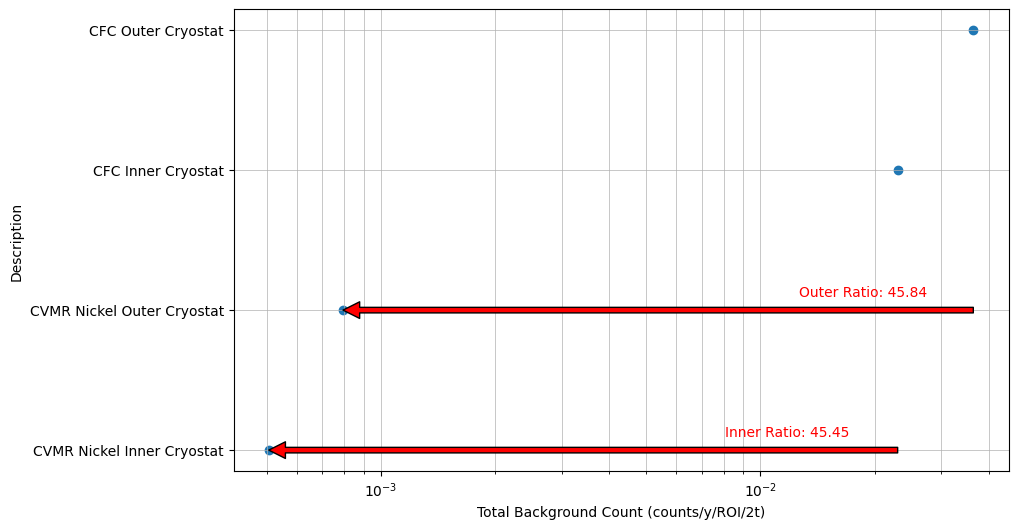

In [18]:
# Creating the plot with red horizontal lines to show the ratios
# Adjusting the plot to show the grid for the 1, 2, 3, etc. log values
# Prepare data for plotting
descriptions = [component['Description'] for component in components_data]
background_counts = [component['Total Background Count'] for component in components_data]

# Find the relevant components and their background counts
cfc_inner_background = cfc_outer_background = nickel_inner_background = nickel_outer_background = None

for component in components_data:
    if 'CFC Inner Cryostat' in component['Description']:
        cfc_inner_background = component['Total Background Count']
    elif 'CFC Outer Cryostat' in component['Description']:
        cfc_outer_background = component['Total Background Count']
    elif 'CVMR Nickel Inner Cryostat' in component['Description']:
        nickel_inner_background = component['Total Background Count']
    elif 'CVMR Nickel Outer Cryostat' in component['Description']:
        nickel_outer_background = component['Total Background Count']

# Calculate the ratios
inner_ratio = cfc_inner_background / nickel_inner_background if cfc_inner_background and nickel_inner_background else None
outer_ratio = cfc_outer_background / nickel_outer_background if cfc_outer_background and nickel_outer_background else None

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(background_counts, descriptions)
plt.xscale('log')
plt.grid(True, which="both", ls="-", linewidth=0.5)

# Adding red lines with arrow style for the ratios
if inner_ratio:
    plt.annotate('', xy=(nickel_inner_background, 0), xytext=(cfc_inner_background, 0),
                 arrowprops=dict(facecolor='red'))
    plt.annotate(f'Inner Ratio: {inner_ratio:.2f}', 
                 ((nickel_inner_background + cfc_inner_background) / 2, 0), 
                 textcoords="offset points", xytext=(0,10), ha='center', color='red')

if outer_ratio:
    plt.annotate('', xy=(nickel_outer_background, 1), xytext=(cfc_outer_background, 1),
                 arrowprops=dict(facecolor='red'))
    plt.annotate(f'Outer Ratio: {outer_ratio:.2f}', 
                 ((nickel_outer_background + cfc_outer_background) / 2, 1), 
                 textcoords="offset points", xytext=(0,10), ha='center', color='red')


# Adding labels and title
plt.xlabel('Total Background Count (counts/y/ROI/2t)')
plt.ylabel('Description')
#plt.title('Total Background Count of CFC/Nickel Cryostats with 2019 geometry')
plt.show()


Using fits of the Hit Efficiencies from the paper "HFE and Spherical Cryostats MC Study" by Brodsky in 2016 (LLNL-TR-703361) we can extrapolate the impact of different HFE thicknesses on the background noise comming from Nickel Cryostats.

In [10]:
file_path = 'hit_efficiencies_data.csv'
data = bgd.read_filter_convert(file_path)

# Convert hfe_thickness and efficiencies to numpy arrays
hfe_thickness = np.array(data.iloc[:, 0])
efficiencies = [
    [np.array(data.iloc[:, 1]), np.array(data.iloc[:, 3])],
    [np.array(data.iloc[:, 2]), np.array(data.iloc[:, 4])]
]

y = 1.98e-06 * exp(-6.91e-02 * x), R^2 = 1.00
y = 9.63e-07 * exp(-8.03e-02 * x), R^2 = 0.94
y = 7.08e-07 * exp(-6.42e-02 * x), R^2 = 1.00
y = 3.83e-07 * exp(-7.45e-02 * x), R^2 = 1.00


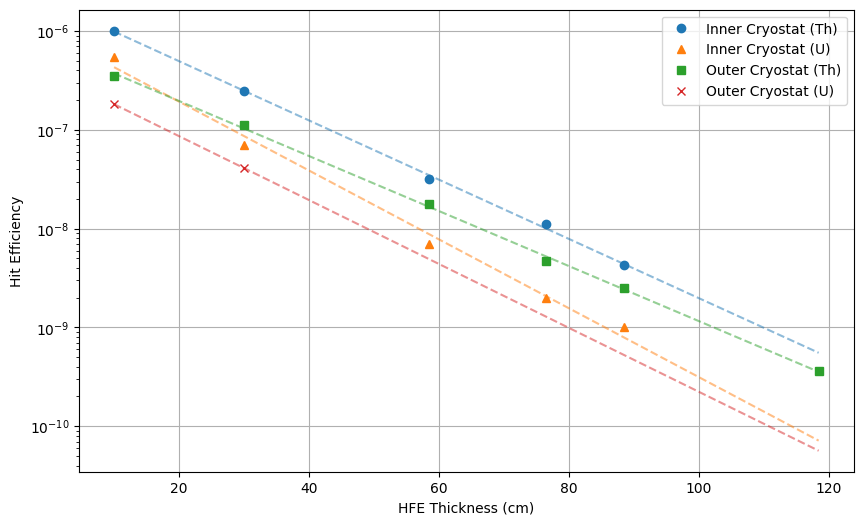

In [12]:
# Plotting
labels = [["Inner Cryostat (Th)", "Inner Cryostat (U)"], ["Outer Cryostat (Th)", "Outer Cryostat (U)"]]
markers = [["o", "^"], ["s", "x"]]

plt.figure(figsize=(10, 6))
trendline_info = []

for i in range(2):
    for j in range(2):
        eff = efficiencies[i][j]
        valid_points = ~np.isnan(eff)
        valid_thickness, valid_efficiencies = hfe_thickness[valid_points], eff[valid_points]


        line, = plt.plot(hfe_thickness, eff, label=labels[i][j], marker=markers[i][j], linestyle='None')

        if len(valid_efficiencies) > 1:
            coeffs = np.polyfit(valid_thickness, np.log(valid_efficiencies), 1)
            trendline = np.exp(coeffs[1]) * np.exp(coeffs[0] * hfe_thickness)
            plt.plot(hfe_thickness, trendline, linestyle='--', alpha=0.5, color=line.get_color())

            r_squared = r2_score(valid_efficiencies, np.exp(coeffs[1]) * np.exp(coeffs[0] * valid_thickness))
            equation = f'y = {np.exp(coeffs[1]):.2e} * exp({coeffs[0]:.2e} * x), R^2 = {r_squared:.2f}'
            print(equation)
            trendline_info.append([np.exp(coeffs[1]), coeffs[0]])

plt.xlabel('HFE Thickness (cm)')
plt.ylabel('Hit Efficiency')
#plt.title('CFC Cryostats Hit Efficiencies for Uranium & Thorium')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
hfe_thickness = np.arange(0, 150.5, 0.5)

background_noise_inner = bgd.calculate_background_noise(U_activity_nickel, IC_nickel_mass, trendline_info[0], hfe_thickness) + \
                         bgd.calculate_background_noise(Th_activity_nickel, IC_nickel_mass, trendline_info[1], hfe_thickness)

background_noise_outer = bgd.calculate_background_noise(U_activity_nickel, OC_nickel_mass, trendline_info[2], hfe_thickness) + \
                         bgd.calculate_background_noise(Th_activity_nickel, OC_nickel_mass, trendline_info[3], hfe_thickness)

# Find intersection points
inner_index = bgd.find_nearest_index(background_noise_inner, cfc_inner_background)
outer_index = bgd.find_nearest_index(background_noise_outer, cfc_outer_background)

# Extract the corresponding thickness values
inner_intersection_thickness = hfe_thickness[inner_index]
outer_intersection_thickness = hfe_thickness[outer_index]

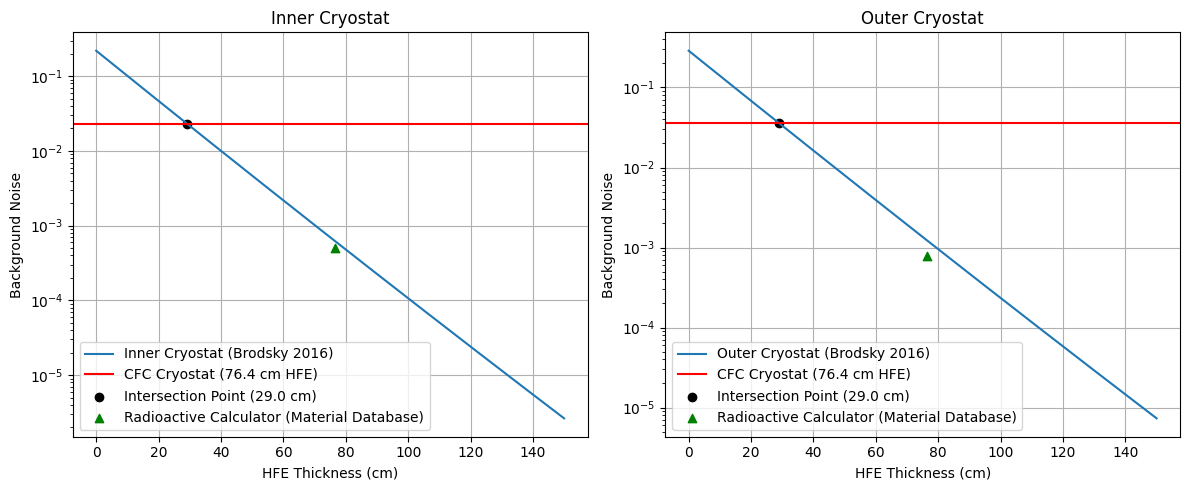

In [15]:
plt.figure(figsize=(12, 5))

# Inner Cryostat Plot
plt.subplot(1, 2, 1)
plt.plot(hfe_thickness, background_noise_inner, label='Inner Cryostat (Brodsky 2016)')
plt.axhline(cfc_inner_background, color='r', label='CFC Cryostat (76.4 cm HFE)')
plt.scatter(inner_intersection_thickness, cfc_inner_background, color='black', 
            label=f'Intersection Point ({inner_intersection_thickness:.1f} cm)')
plt.scatter(76.4, 5.06E-04, color='g', label='Radioactive Calculator (Material Database)', marker="^")
plt.xlabel('HFE Thickness (cm)')
plt.ylabel('Background Noise')
plt.yscale('log')
plt.title('Inner Cryostat')
plt.grid(True)
plt.legend()

# Outer Cryostat Plot
plt.subplot(1, 2, 2)
plt.plot(hfe_thickness, background_noise_outer, label='Outer Cryostat (Brodsky 2016)')
plt.axhline(cfc_outer_background, color='r', label='CFC Cryostat (76.4 cm HFE)')
plt.scatter(outer_intersection_thickness, cfc_outer_background, color='black', 
            label=f'Intersection Point ({outer_intersection_thickness:.1f} cm)')
plt.scatter(76.4, 7.94E-04, color='g', label='Radioactive Calculator (Material Database)', marker="^")
plt.xlabel('HFE Thickness (cm)')
plt.ylabel('Background Noise')
plt.yscale('log')
plt.title('Outer Cryostat')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


To get the equivalent background from a nickel background compared to a CFC one, we can use 29cm of HFE instead of 76cm. These results are probably overestimated since here the reduction of Nickel coming from the geometry change of the Cryostats with the HFE quantity reduction is not taken into account. The values estimated with the Material Database Radioactivity Calculator & the 2019 geometry appears to be really close to the results extrapolated from Jason's 2016 paper.